In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import heapq

Segmentation methods to implement:

Agglomerative clustering

Mean shift clustering

## Agglomerative clustering

In [ ]:
class Cluster:
    count = 0
    
    def __init__(self, centroid, left_cluster=None, right_cluster=None, neighbors=None):
        """
        Class to represent a cluster in the agglomerative clustering algorithm.
        :param centroid: (x, y, red, green, blue)
        :param left_cluster: 
        :param right_cluster: 
        :param neighbors: list of 8-point neighboring clusters
        """
        self.centroid = centroid
        self.left_cluster = left_cluster
        self.right_cluster = right_cluster
        self.neighbors = set(neighbors or [])
        self.merged = False
        self.num_points = 0 if left_cluster is None and right_cluster is None else 1
        if left_cluster is not None:
            self.num_points += left_cluster.num_points
            left_cluster.merged = True
        if right_cluster is not None:
            self.num_points += right_cluster.num_points
            right_cluster.merged = True
            
        self.id = Cluster.count
        Cluster.count += 1
        
        
    def merge(self, other):
        """
        Merge two clusters.
        :param other: other cluster to merge with
        :return: new cluster
        """
        new_centroid = (
            (self.centroid[0] * self.num_points + other.centroid[0] * other.num_points) / (self.num_points + other.num_points),
            (self.centroid[1] * self.num_points + other.centroid[1] * other.num_points) / (self.num_points + other.num_points),
            (self.centroid[2] * self.num_points + other.centroid[2] * other.num_points) / (self.num_points + other.num_points),
            (self.centroid[3] * self.num_points + other.centroid[3] * other.num_points) / (self.num_points + other.num_points),
            (self.centroid[4] * self.num_points + other.centroid[4] * other.num_points) / (self.num_points + other.num_points),
        )
        new_neighbors = set(self.neighbors).union(other.neighbors)
        new_neighbors.discard(self)
        new_neighbors.discard(other)
        return Cluster(new_centroid, self, other, new_neighbors)
    
    def distance(self, other, color_weight=1.0, spatial_weight=1.0):
        """
        Calculate the distance between two clusters.
        :param spatial_weight: 
        :param color_weight: 
        :param other: other cluster to calculate distance to
        :return: distance
        """
        spatial_distance = np.sqrt((self.centroid[0] - other.centroid[0]) ** 2 + (self.centroid[1] - other.centroid[1]) ** 2)
        color_distance = np.sqrt((self.centroid[2] - other.centroid[2]) ** 2 + (self.centroid[3] - other.centroid[3]) ** 2 + (self.centroid[4] - other.centroid[4]) ** 2)
        return color_weight * color_distance + spatial_weight * spatial_distance
    
    def __lt__(self, other):
        # prioritize larger clusters in the heap
        return self.num_points > other.num_points
    
    def get_pixels(self):
        """
        Get the pixels in the cluster.
        :return: list of pixels
        """
        pixels = []
        if self.left_cluster is not None:
            pixels += self.left_cluster.get_pixels()
        if self.right_cluster is not None:
            pixels += self.right_cluster.get_pixels()
        if not pixels:
            return [self.centroid[0:2]]  # return the centroid coordinates
        return pixels

In [ ]:
def create_clusters(image):
    """
    Create initial clusters from image.
    :param image: image to create clusters from
    :return: list of clusters
    """
    clusters = []
    height, width, _ = image.shape
    for i in range(height):
        for j in range(width):
            pixel = image[i, j]
            cluster = Cluster((i, j, pixel[0], pixel[1], pixel[2]))
            clusters.append(cluster)
    return clusters

def create_neighbors(clusters, width, height, connectivity=4):
    """
    Create neighbors for each cluster.
    :param clusters: list of clusters
    :param width: width of image
    :param height: height of image
    :param connectivity: 4 or 8 (neighbor type)
    :return: None
    """
    index = lambda r, c: r * width + c  # Converts (row, col) -> linear index

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # 4-connectivity
    if connectivity == 8:
        directions += [(-1, -1), (-1, 1), (1, -1), (1, 1)]  # add diagonals for 8-connectivity

    for r in range(height):
        for c in range(width):
            current = clusters[index(r, c)]
            neighbors = []
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < height and 0 <= nc < width:
                    neighbor = clusters[index(nr, nc)]
                    neighbors.append(neighbor)
            current.neighbors = neighbors
        
def create_distance_heap(clusters, color_weight=1.0, spatial_weight=1.0):
    """
    Create a heap of distances between neighboring clusters.
    :param clusters: 
    :return: heap 
    """
    heap = []
    seen_pairs = set()
    for cluster in clusters:
        for neighbor in cluster.neighbors:
            pair = tuple(sorted([cluster.id, neighbor.id]))
            if pair not in seen_pairs:
                distance = cluster.distance(neighbor, color_weight, spatial_weight)
                heapq.heappush(heap, (distance, cluster, neighbor))
                seen_pairs.add(pair)
    
    return heap

In [ ]:
def agglomerative_clustering(image, num_clusters, color_weight=1.0, spatial_weight=1.0, connectivity=4):
    """
    Perform agglomerative clustering on an image.
    :param image: image to cluster
    :param num_clusters: number of clusters to create
    :param color_weight: weight for color distance
    :param spatial_weight: weight for spatial distance
    :param connectivity: 4 or 8 (neighbor type)
    :return: clustered image
    """
    clusters = create_clusters(image)
    height, width, _ = image.shape
    create_neighbors(clusters, width, height, connectivity)
    
    heap = create_distance_heap(clusters, color_weight, spatial_weight)
        
    while len(clusters) > num_clusters:
        _, cluster1, cluster2 = heapq.heappop(heap)
        if cluster1.merged or cluster2.merged:
            continue
            
        new_cluster = cluster1.merge(cluster2)
        clusters.remove(cluster1)
        clusters.remove(cluster2)
        clusters.append(new_cluster)
        
        for neighbor in new_cluster.neighbors:
            if neighbor.merged:
                continue
            distance = new_cluster.distance(neighbor, color_weight, spatial_weight)
            heapq.heappush(heap, (distance, new_cluster, neighbor))
            
    return clusters  ## for now

In [ ]:
# create a 

In [2]:
from scipy.spatial.distance import pdist, squareform

def custom_agglomerative_clustering(image, n_clusters=10):
    """
    Implement custom agglomerative clustering from scratch.
    
    Parameters:
    -----------
    image_path : str
        Path to the input image
    n_clusters : int, optional (default=10)
        Number of clusters to form
        
    Returns:
    --------
    segmented_image : ndarray
        The segmented image
    labels : ndarray
        Labels of each point
    """
    
    # Reshape the image into a feature vector
    height, width = image.shape[:2]
    n_pixels = height * width
    
    # Include spatial information (position) with color features
    X = np.zeros((n_pixels, 5 if len(image.shape) == 3 else 3))
    
    # Scale factors for position and color features
    position_scale = 0.1  # Adjust this value to control the influence of position
    
    for i in range(height):
        for j in range(width):
            pixel_idx = i * width + j
            # Add scaled position features
            X[pixel_idx, 0] = i * position_scale
            X[pixel_idx, 1] = j * position_scale
            
            if len(image.shape) == 3:
                # Add color features
                X[pixel_idx, 2:] = image[i, j]
            else:
                # Add grayscale intensity
                X[pixel_idx, 2] = image[i, j]
    
    # Compute distance matrix
    distances = squareform(pdist(X, metric='euclidean'))
    
    # Initialize each pixel as a separate cluster
    current_clusters = np.arange(n_pixels)
    active_clusters = set(range(n_pixels))
    
    # Perform agglomerative clustering
    while len(active_clusters) > n_clusters:
        # Find the two closest clusters
        min_dist = float('inf')
        merge_i, merge_j = -1, -1
        
        # This is computationally expensive - using a priority queue would be more efficient
        for i in active_clusters:
            for j in active_clusters:
                if i < j and distances[i, j] < min_dist:
                    min_dist = distances[i, j]
                    merge_i, merge_j = i, j
        
        # Merge clusters
        for k in range(n_pixels):
            if current_clusters[k] == merge_j:
                current_clusters[k] = merge_i
        
        # Update active clusters
        active_clusters.remove(merge_j)
        
        # Print progress periodically
        if len(active_clusters) % 100 == 0:
            print(f"Remaining clusters: {len(active_clusters)}")
    
    # Assign unique labels to each cluster
    labels = np.zeros(n_pixels, dtype=int)
    for i, cluster_idx in enumerate(np.unique(current_clusters)):
        labels[current_clusters == cluster_idx] = i
    
    # Reshape labels to match original image shape
    labels = labels.reshape(height, width)
    
    # Create segmented image (mean color for each segment)
    segmented_image = np.zeros_like(image)
    
    # For each cluster, assign the mean color of the region
    for label in np.unique(labels):
        mask = labels == label
        
        if len(image.shape) == 3:
            # Colored image
            for channel in range(3):
                segmented_image[mask, channel] = np.mean(image[mask, channel])
        else:
            # Grayscale image
            segmented_image[mask] = np.mean(image[mask])
    
    return segmented_image, labels

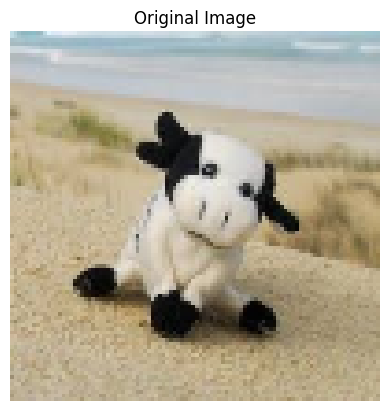

In [4]:
image = cv.imread('segment_images/cow-toy.jpeg')
# Resize image to speed up processing
image = cv.resize(image, (100, 100))
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')
plt.show()

In [5]:
segmented_image, labels = custom_agglomerative_clustering(image, n_clusters=10)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Segmented Image')
plt.imshow(segmented_image)
plt.axis('off')
plt.show()

KeyboardInterrupt: 

## Mean shift clustering

In [104]:
# feature space includes pixel colors and spatial coordinates
def create_features(image, with_spatial_coords=False):
    """
    Create feature space for mean shift clustering.
    :param image: image to create features from
    :return: feature space, each pixel is represented by its color and coordinates (5d vector)
    """
    # normalize values to [0, 1]
    image = image.astype(np.float32)
    h, w, c = image.shape
    flat_image = image.reshape(-1, c)
    if with_spatial_coords:
        coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2)
        flat_image = np.concatenate([flat_image, coords], axis=1)
    return flat_image

In [4]:
def mean_shift_single_center(features, start_idx, bandwidth, max_iterations=300, tolerance=1e-3):
    center = features[start_idx]
    for it in range(max_iterations):
        distances = np.linalg.norm(features - center, axis=1)
        
        in_bandwidth = features[distances < bandwidth]
        if len(in_bandwidth) == 0:
            break
            
        new_center = np.mean(in_bandwidth, axis=0)
        if np.linalg.norm(new_center - center) < tolerance:
            break
            
        center = new_center
    
    return center

In [126]:
# complete workflow
image = cv.imread('segment_images/cow-toy.jpeg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
features = create_features(image)
bandwidth = 100

In [127]:
n_samples = features.shape[0]
shuffled_features = features.copy()
np.random.seed(7)
np.random.shuffle(shuffled_features)
centers = []
visited = np.zeros(n_samples, dtype=bool)

merge_threshold = bandwidth / 2

In [128]:
last_addition = 0
for i in range(n_samples):
    if i - last_addition >= 100:
        break  # or reshuffle???
        
    if visited[i]:
        continue
        
    center = mean_shift_single_center(shuffled_features, i, bandwidth, 300, 1e-3)
    
    distances = np.linalg.norm(shuffled_features - center, axis=1)
    visited[distances < merge_threshold] = True
    
    # only append center if not within merge_threshold of existing centers
    if any(np.linalg.norm(center - c) < merge_threshold for c in centers):
        continue
    
    centers.append(center)
    last_addition = i
    print(f"Iteration {i+1}/{n_samples}")
    print(f"Current center: {center}")
    print(f"Samples left: {np.sum(~visited)}")
    print(f"Centers found: {len(centers)}")

Iteration 1/50625
Current center: [176.25390335 160.43258984 127.22664188 155.62478315 163.2464684 ]
Samples left: 47088
Centers found: 1
Iteration 2/50625
Current center: [195.19104861 188.91091367 171.74518934  74.44614434  82.12529102]
Samples left: 43998
Centers found: 2
Iteration 3/50625
Current center: [194.18340915 179.11003479 148.46919989 141.34348408  61.20957988]
Samples left: 40402
Centers found: 3
Iteration 8/50625
Current center: [ 32.45237464  28.84664367  22.76386309 133.31652958 110.03847174]
Samples left: 39989
Centers found: 4


In [129]:
labels = np.zeros(features.shape[0], dtype=int)
distances = np.zeros((features.shape[0], len(centers)), dtype=float)

In [130]:
distances = np.linalg.norm(features[:, np.newaxis] - centers, axis=2)

In [131]:
labels = np.argmin(distances, axis=1).reshape(image.shape[0], image.shape[1])

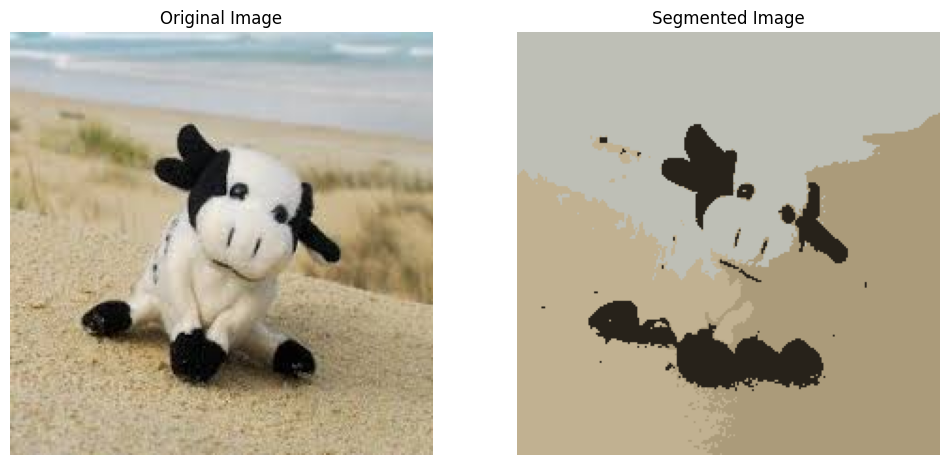

In [132]:
segmented_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
for i in range(len(centers)):
    segmented_image[labels == i] = np.mean(features[labels.reshape(-1) == i], axis=0)[:3]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Segmented Image')
plt.imshow(segmented_image)
plt.axis('off')
plt.show()